In [1]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.image as mpimg
from scipy.ndimage import convolve
import time

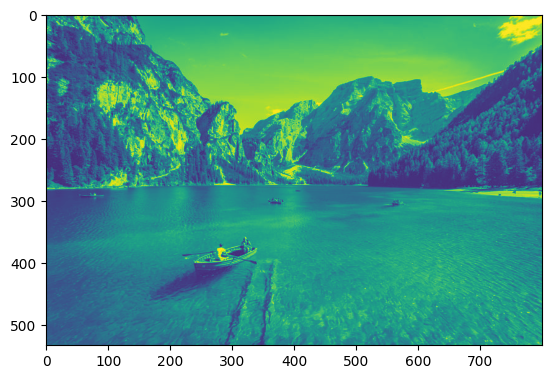

In [7]:
def brightness(img):
    a = [[0 for _ in range(len(img[0]))] for _ in range(len(img))]
    for i in range(len(img)):
        for j in range(len(img[0])):
            a[i][j] = 0.3 * img[i][j][0] + 0.59 * img[i][j][1] + 0.11 * img[i][j][2]
    return a

imgorg = mpimg.imread('img6.jpg')
img = brightness(imgorg)
# Display the image
plt.imshow(img)
plt.show()

In [3]:
kernel0 = np.array([
                [-0.125, 0.0, 0.125],
                [-0.25, 0.0, 0.25],
                [-0.125, 0.0, 0.125]])
kernel1= np.array([
                [-0.125, -0.25, -0.125],
                [0.0,0.0,0.0],
                [0.125, 0.25, 0.125]])

def convolve_img(img, kernel):
    return convolve(img, kernel) 

# plt.imshow(convolve_img(img,kernel1))

In [4]:
def partial_derivative(img):
    grx = convolve_img(img, kernel0)
    gry = convolve_img(img, kernel1)
    return grx, gry

def least_edgy_ver(edged_img):
    least_e = np.zeros_like(edged_img)
    dirs = np.zeros_like(edged_img)
    for i in range(len(edged_img[0])):
        least_e[-1][i] = edged_img[-1][i]
    m, n = len(edged_img), len(edged_img[0])

    for i in range(m-2,-1,-1):
        for j in range(n):
            j1, j2 = max(0, j-1), min(j+1, n-1)
            min_e = float('inf')
            direction = 0
            for pi,k in enumerate(least_e[i+1][j1:j2+1]):
                if k < min_e:
                    min_e = k
                    direction = pi
            
            least_e[i][j] += edged_img[i][j] + min_e
            dirs[i][j] = (-1,0,1)[direction + (j==0)]

    return least_e, dirs

def least_edgy_hor(edged_img):
    least_e = np.zeros_like(edged_img)
    dirs = np.zeros_like(edged_img)
    for i in range(len(edged_img)):
        least_e[i][-1] = edged_img[i][-1]
    m, n = len(edged_img), len(edged_img[0])
    for j in range(n-2, -1, -1):
        for i in range(m):
            i1, i2 = max(0, i-1), min(i+1, m-1)
            min_e = float('inf')
            direction = 0
            for pi, k in enumerate(least_e[i1:i2+1,j+1]):
                if k < min_e:
                    min_e = k
                    direction = pi
            least_e[i][j] += edged_img[i][j] + min_e
            dirs[i][j] = (-1,0,1)[direction + (i==0)]
    return least_e, dirs


def get_seam_at_ver(dirs, j):
    m = len(dirs)
    js = [0 for _ in range(m)]
    js[0] = j
    for i in range(1, m):
        js[i] = js[i-1]+dirs[i-1][int(js[i-1])]
    return js

def get_seam_at_hor(dirs, i):
    n = len(dirs[0])
    js = [0 for _ in range(n)]
    js[0] = i
    for j in range(1, n):
        js[j] = js[j-1] + dirs[int(js[j-1])][j-1]

    return js

def rm_path_ver(img, path):
    img = np.array(img)
    n = len(img[0])
    cut_img = img[:, :-1].copy()

    for i, j in enumerate(path):
        j = int(j)
        cut_img[i,:j] = img[i,:j]
        cut_img[i,j:] = img[i,j+1:]

    return cut_img

def rm_path_hor(img, path):
    img = np.array(img)
    m = len(img)
    cut_img = img[:-1, :].copy()
    # print(len(cut_img), len(img))
    for i, j in enumerate(path):
        #i is col and j is row here
        j = int(j)
        cut_img[:j,i] = img[:j,i]
        cut_img[j:,i] = img[j+1:,i]

    return cut_img

# def shrink_horizontally(img,edged, n):
#     new_img = np.copy(img)
#     for i in range(n):  
#         dp, dirs = least_edgy_ver(edged)
#         m_col = float('inf')
#         col = 0
#         for j in range(0,len(dp[0])):
#             if m_col > dp[0][j]:
#                 m_col = dp[0][j]
#                 col = j 
#         seam = get_seam_at_ver(dirs, col)
#         new_img = rm_path_ver(new_img, seam)
#         edged = rm_path_ver(edged, seam)

#     return new_img

# def shrink_vertically(img,edged, n):
#     new_img = np.copy(img)
#     for i in range(n):
#         dp, dirs = least_edgy_hor(edged)
#         m_row = float('inf')
#         row = 0
#         for j in range(0,len(dp)):
#             if m_row > dp[j][0]:
#                 m_row = dp[j][0]
#                 row = j
#         seam = get_seam_at_hor(dirs, row)
#         new_img = rm_path_hor(new_img, seam)
#         edged = rm_path_hor(edged, seam)

#     return new_img

# Recompute the energy for the new image
		# Note, this currently involves rerunning the convolution
		# on the whole image, but in principle the only values that
		# need recomputation are those adjacent to the seam, so there
		# is room for a meanintful speedup here.
#		e = edgeness(img)
def recompute_dir_neighbours_ver(seam, dirs, dp):
    m = len(dirs)
    n = len(dirs[0])
    for i in range(len(seam)-2, -1,-1):
        j = int(seam[i])
        if j == 0:
            # If we removed 0 column then we have to update 0 column
            j1, j2 = 0, 1
            min_e = float('inf')
            direction = 0
            for pi,k in enumerate(dp[i+1][j1:j2+1]):
                if k < min_e:
                    min_e = k
                    direction = pi
            
            dirs[i][0] = (0,1)[direction]
        elif j == n:
            j = j-1
            # If we removed n-1 column then we have to update n-1 column
            j1, j2 = j-1, j
            min_e = float('inf')
            direction = 0
            for pi,k in enumerate(dp[i+1][j1:j2+1]):
                if k < min_e:
                    min_e = k
                    direction = pi
            dirs[i][j] = (-1, 0)[direction]
        else:
            j1, j2 = max(0, j-2), min(j, n-1)
            min_e = float('inf')
            direction = 0
            for pi,k in enumerate(dp[i+1][j1:j2+1]):
                if k < min_e:
                    min_e = k
                    direction = pi
            
            dirs[i][j-1] = (-1,0,1)[direction + ((j-1)==0)]
            j1, j2 = max(0, j-1), min(j+1, n-1)
            min_e = float('inf')
            direction = 0
            for pi,k in enumerate(dp[i+1][j1:j2+1]):
                if k < min_e:
                    min_e = k
                    direction = pi
            
            dirs[i][j] = (-1,0,1)[direction + (j==0)]
            
        
    return dirs
def recompute_dir_neighbours_hor(seam, dirs, dp):
    m = len(dirs)
    n = len(dirs[0])
    for j in range(len(seam)-2,-1,-1):
        i = int(seam[j])
        if i == 0:
            i1, i2 = 0, 1
            # print(i1, i2, i)
            min_e = float('inf')
            direction = 0
            for pi, k in enumerate(dp[i1:i2+1,j+1]):
                if k < min_e:
                    min_e = k
                    direction = pi
            # dp[i-1][j] = dp[i-1][j] + min_e
            dirs[0][j] = (0,1)[direction]
        elif i == m:
            i = i-1
            i1, i2 = i-1, i
            min_e = float('inf')
            direction = 0
            for pi, k in enumerate(dp[i1:i2+1,j+1]):
                if k < min_e:
                    min_e = k
                    direction = pi
            # dp[i][j] = edged_img[i+1][j] + min_e
            dirs[i][j] = (-1,0)[direction]
        else:
            i1, i2 = max(0, i-2), min(i, m-1)
            # print(i1, i2, i)
            min_e = float('inf')
            direction = 0
            for pi, k in enumerate(dp[i1:i2+1,j+1]):
                if k < min_e:
                    min_e = k
                    direction = pi
            # dp[i-1][j] = dp[i-1][j] + min_e
            dirs[i-1][j] = (-1,0,1)[direction+((i-1)==0)]
            i1, i2 = max(0, i-1), min(i+1, m-1)
            min_e = float('inf')
            direction = 0
            for pi, k in enumerate(dp[i1:i2+1,j+1]):
                if k < min_e:
                    min_e = k
                    direction = pi
            # dp[i][j] = edged_img[i+1][j] + min_e
            dirs[i][j] = (-1,0,1)[direction+(i==0)]
        
    return dirs
def shrink_horizontally(img,edged, n):
    new_img = np.copy(img)
    dp, dirs = least_edgy_ver(edged)
    for i in range(n):  
        m_col = float('inf')
        col = 0
        for j in range(0,len(dp[0])):
            if m_col > dp[0][j]:
                m_col = dp[0][j]
                col = j 
        seam = get_seam_at_ver(dirs, col)
        new_img = rm_path_ver(new_img, seam)
        dp = rm_path_ver(dp, seam)
        dirs = rm_path_ver(dirs, seam)
        dirs = recompute_dir_neighbours_ver(seam, dirs, dp)
        # edged = rm_path_ver(edged, seam)

    return new_img


    
def shrink_vertically(img,edged, n):
    new_img = np.copy(img)
    dp, dirs = least_edgy_hor(edged)
    for i in range(n):
        m_row = float('inf')
        row = 0
        for j in range(0,len(dp)):
            if m_row > dp[j][0]:
                m_row = dp[j][0]
                row = j
        seam = get_seam_at_hor(dirs, row)
        new_img = rm_path_hor(new_img, seam)
        dp = rm_path_hor(dp, seam)
        dirs = rm_path_hor(dirs, seam)
        dirs = recompute_dir_neighbours_hor(seam, dirs, dp)

        # edged = rm_path_hor(edged, seam)

    return new_img

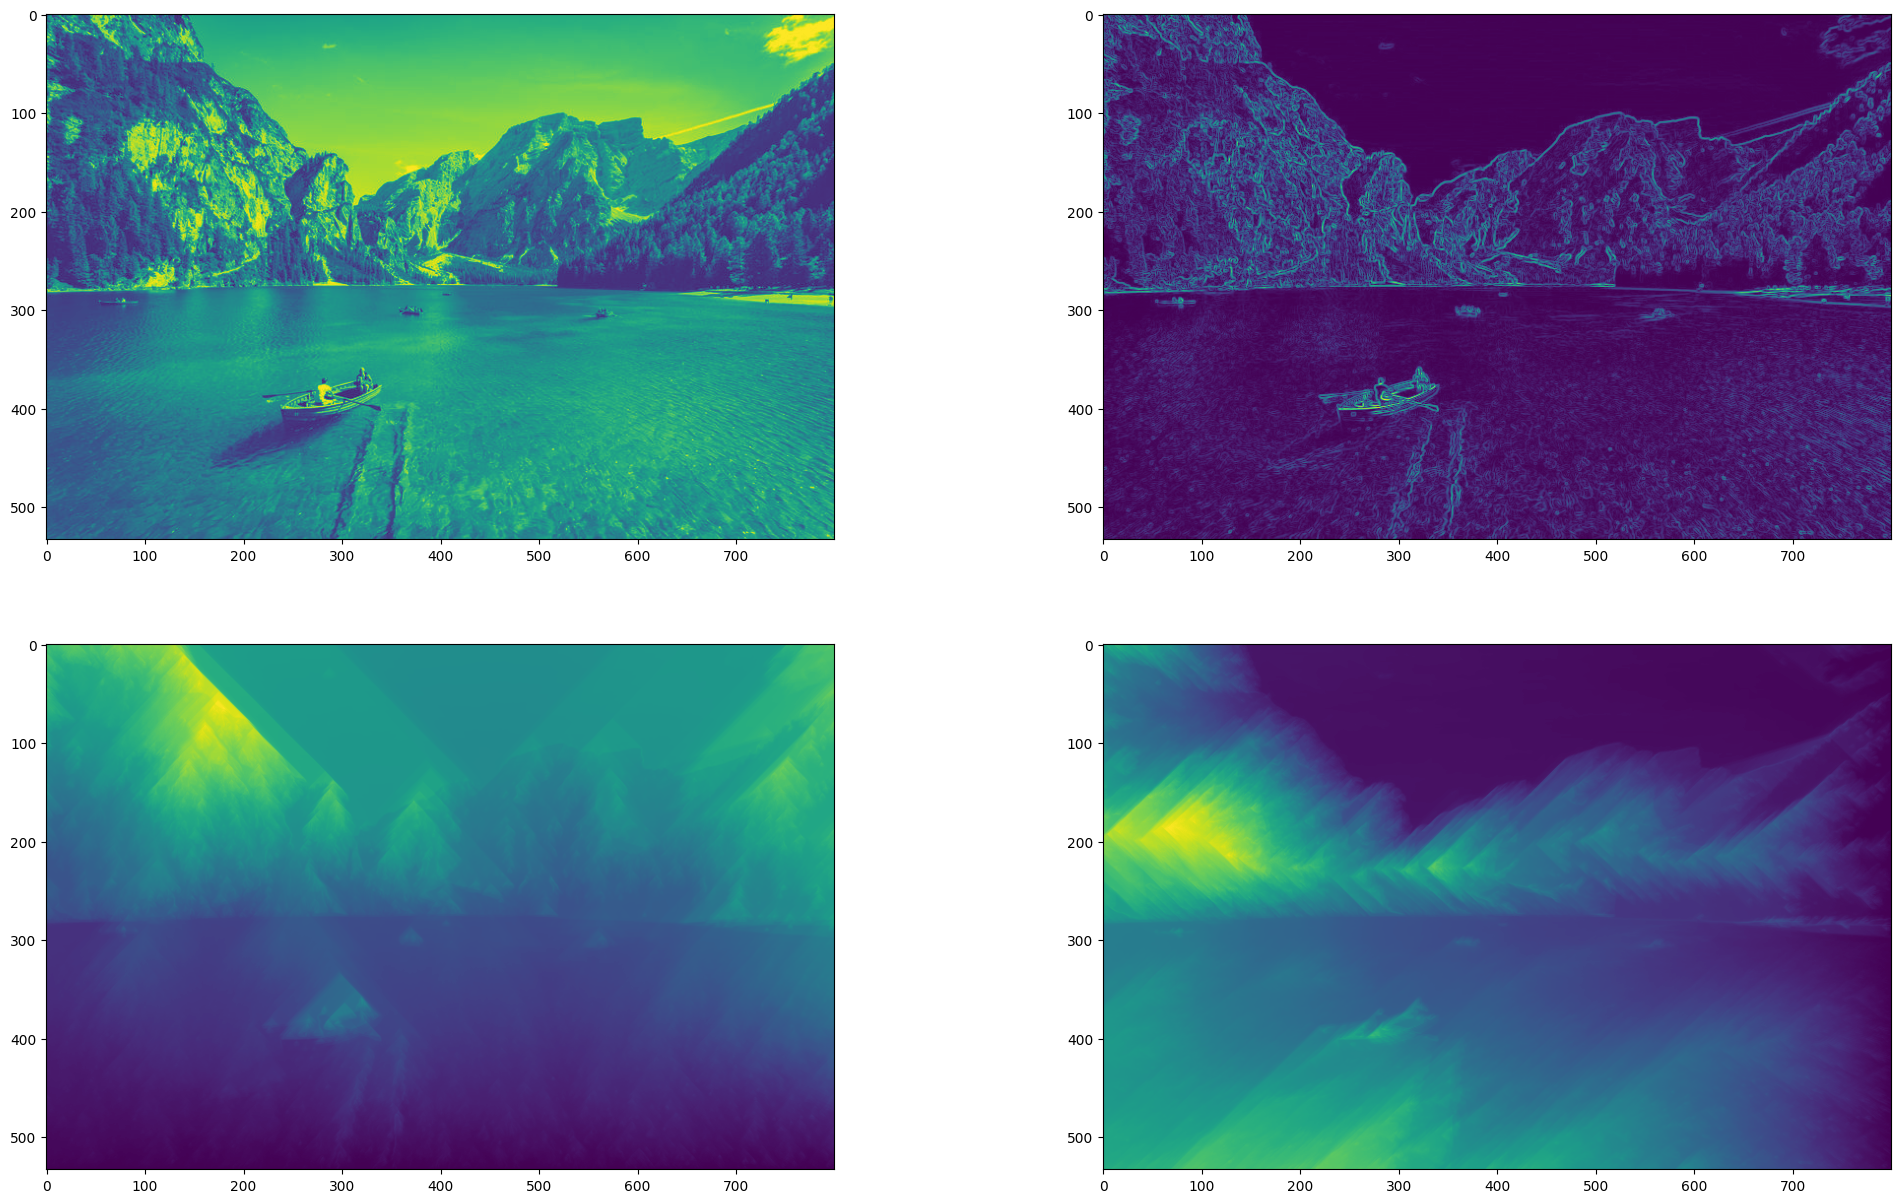

In [9]:
grx, gry = partial_derivative(img)
edged = [[ 0 for _ in range(len(grx[0]))] for _ in range(len(grx))]
for i in range(len(grx)):
    for j in range(len(grx[0])):
        edged[i][j] = ((grx[i][j])**2  + (gry[i][j])**2)**0.5
fig, axes = plt.subplots(2, 2, figsize=(25, 15))
dp1, dirs1 = least_edgy_ver(edged)
dp2, dirs2 = least_edgy_hor(edged)
axes[0][0].imshow(img)
axes[0][1].imshow(edged)
axes[1][0].imshow(dp1)
axes[1][1].imshow(dp2)

It took 11s to shrink horizontally by str(verPx)+ px and vertically by 200px


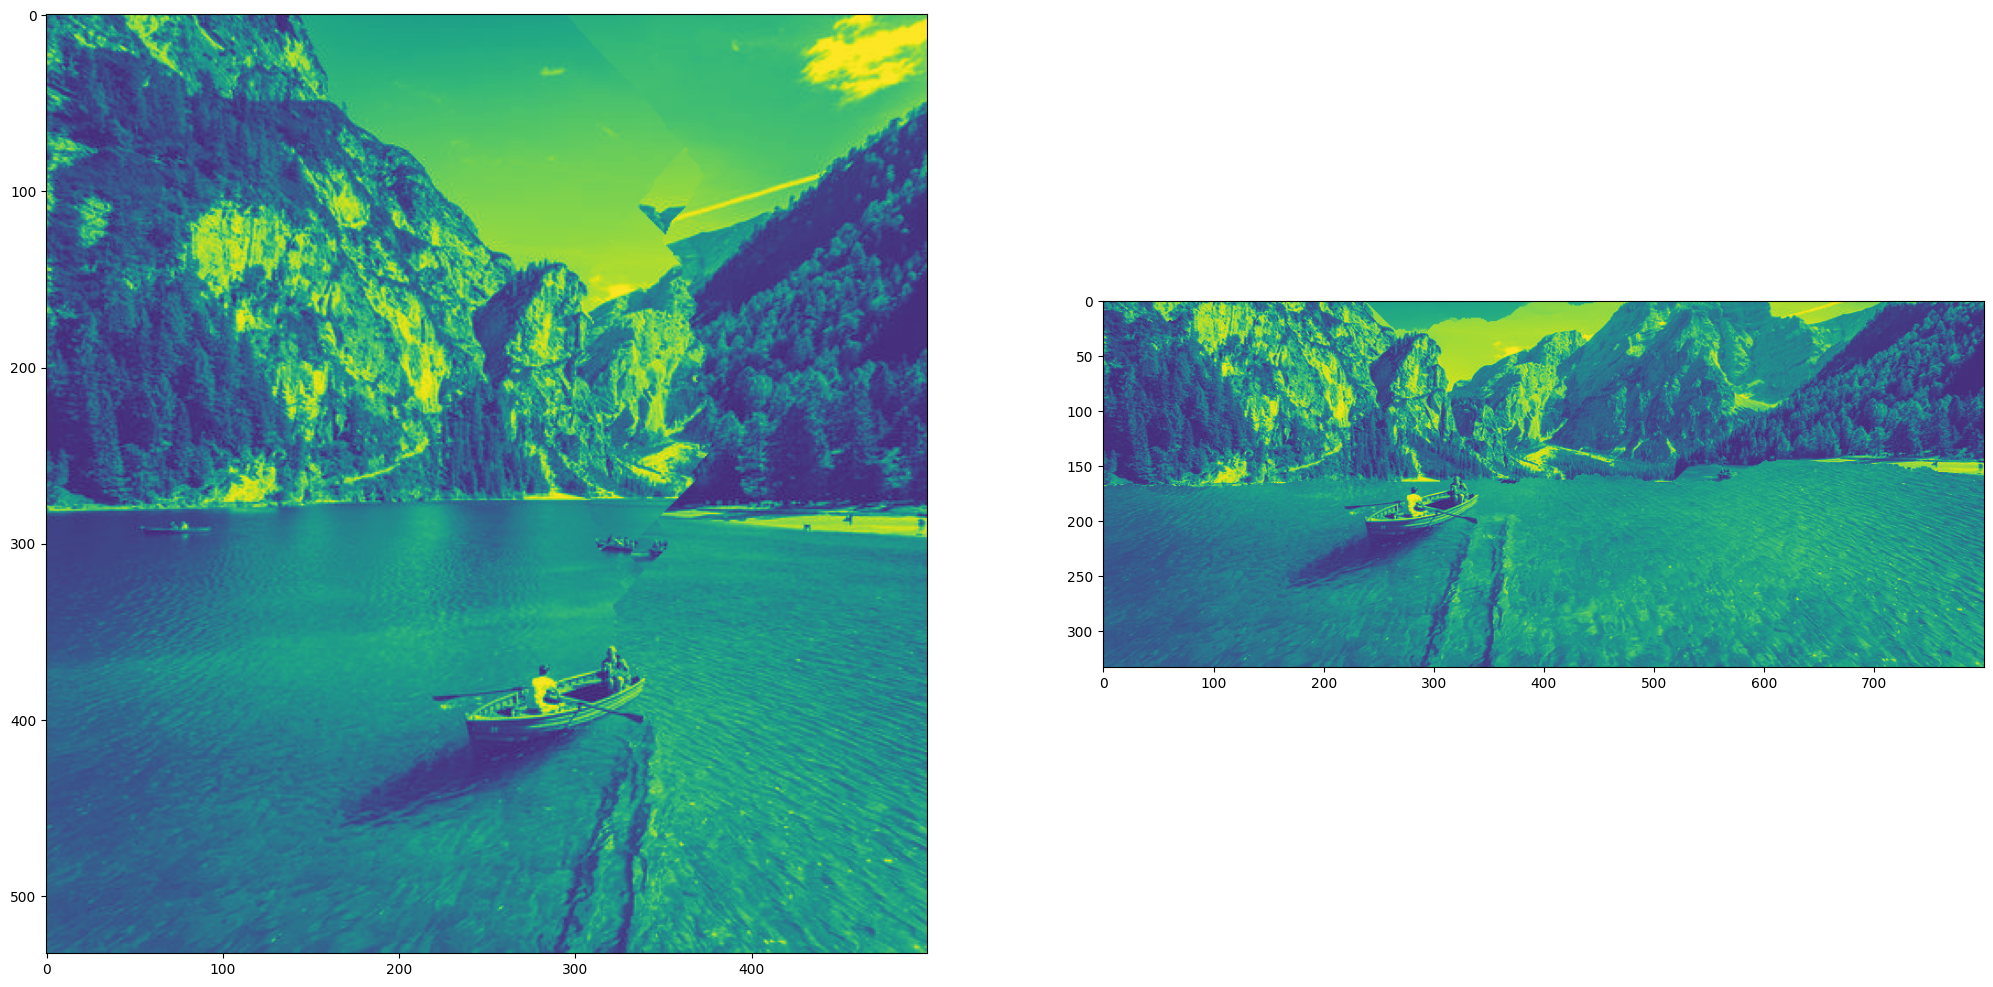

In [12]:
horPx = 300
verPx = 200
fig, axes = plt.subplots(1, 2, figsize=(25, 15))
start = time.time() 
axes[0].imshow(shrink_horizontally(img,edged, horPx))
axes[1].imshow(shrink_vertically(img,edged,verPx))
end = time.time()
print("It took "+str(round(end - start))+"s to shrink horizontally by "+str(horPx)+"px and vertically by "+str(verPx)+"px")